<a href="https://colab.research.google.com/github/tanvigunjal/Computer_Vision/blob/main/Deep%20Learning%20using%20basic%20operations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Implement a simple two-layer neural network and its training algorithm based on back-propagation using only basic matrix operations

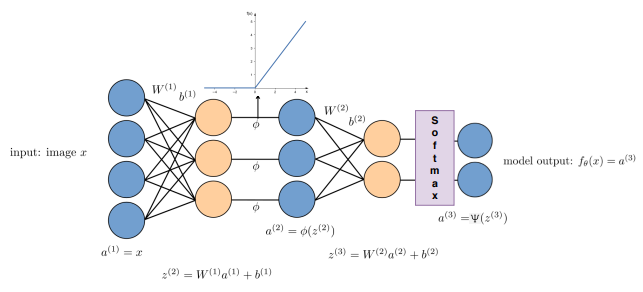

It has an input layer, and two model layers – a hidden and an output layer. In the hidden layer, there are 10 units. The input layer and the hidden layer are connected via linear weighting matrix $W^{(1)}∈ R^{10×4}$  and the bias term $b^{(1)}∈ R^{10}$. The parameters $W^{(1)}$ and $b^{(1)}$ are to be learnt later on. A linear operation is performed, $W^{(1)}x + b^{(1)}$, resulting in a 10 dimensional vector $z^{(2)}$. It is then followed by a relu non-linear activation φ, applied element-wise on each unit, resulting in the activations $a^{(2)} = φ(z^{(2)})$. 

A similar linear operation is performed on $a^{(2)}$, resulting in $z^{(3)} = W^{(2)}a^{(2)} + b^{(2)}$, where $W^{(2)} ∈ R^{3×10}$ and $b^{(2)} ∈ R^{3}$; it is followed by the softmax activation to result in $a^{(3)} = ψ(z^{(3)})$. The softmax function is defined by:

$ψ(u)_i = \frac{exp^{u_i}}{\sum_j exp^{u_j}}$

The final functional form of our model is thus defined by,

$a^{(1)} = x$ 

$z^{(2)} = W^{(1)}a^{(1)} + b^{(1)}$

$a^{(2)} = φ(z^{(2)})$

$z^{(3)} = W^{(2)}a^{(2)} + b^{(2)}$

$f_θ(x) := a^{(3)} = ψ(z^{(3)})$ 

which takes a flattened 4 dimensional vector as input and outputs a 3 dimensional vector, each entry in the output $f_k(x)$ representing the probability of image x corresponding to the class k. We summarily indicate all
the network parameters by $θ = (W^{(1)}, b^{(1)}, W^{(2)}, b^{(2)})$.

Backpropagation: We train the model by solving, 
$min_θ J(θ)$ via  Stochastic gradient descent. 


In [ ]:
#Libraries
from __future__ import print_function
from builtins import range

from random import randrange
from builtins import range
from builtins import object
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from scipy.special import softmax as softm
from six.moves import cPickle as pickle
import os
from matplotlib.pyplot import imread
import platform
from math import sqrt, ceil


try:
    xrange          # Python 2
except NameError:
    xrange = range  # Python 3

In [ ]:
#Load Dataset 
def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == '2':
        return  pickle.load(f)
    elif version[0] == '3':
        return  pickle.load(f, encoding='latin1')
    raise ValueError("invalid python version: {}".format(version))

def load_CIFAR_batch(filename):
    """ load single batch of cifar """
    with open(filename, 'rb') as f:
        datadict = load_pickle(f)
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
        Y = np.array(Y)
        return X, Y

def load_CIFAR10(ROOT):
    """ load all of cifar """
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte


def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'path_to_dataset'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Reshape data to rows
    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)

    return X_train, y_train, X_val, y_val, X_test, y_test

def load_tiny_imagenet(path, dtype=np.float32, subtract_mean=True):
    """
    Load TinyImageNet. Each of TinyImageNet-100-A, TinyImageNet-100-B, and
    TinyImageNet-200 have the same directory structure, so this can be used
    to load any of them.

    Inputs:
    - path: String giving path to the directory to load.
    - dtype: numpy datatype used to load the data.
    - subtract_mean: Whether to subtract the mean training image.

    Returns: A dictionary with the following entries:
    - class_names: A list where class_names[i] is a list of strings giving the
      WordNet names for class i in the loaded dataset.
    - X_train: (N_tr, 3, 64, 64) array of training images
    - y_train: (N_tr,) array of training labels
    - X_val: (N_val, 3, 64, 64) array of validation images
    - y_val: (N_val,) array of validation labels
    - X_test: (N_test, 3, 64, 64) array of testing images.
    - y_test: (N_test,) array of test labels; if test labels are not available
      (such as in student code) then y_test will be None.
    - mean_image: (3, 64, 64) array giving mean training image
    """
    # First load wnids
    with open(os.path.join(path, 'wnids.txt'), 'r') as f:
        wnids = [x.strip() for x in f]

    # Map wnids to integer labels
    wnid_to_label = {wnid: i for i, wnid in enumerate(wnids)}

    # Use words.txt to get names for each class
    with open(os.path.join(path, 'words.txt'), 'r') as f:
        wnid_to_words = dict(line.split('\t') for line in f)
        for wnid, words in wnid_to_words.items():
            wnid_to_words[wnid] = [w.strip() for w in words.split(',')]
    class_names = [wnid_to_words[wnid] for wnid in wnids]

    # Next load training data.
    X_train = []
    y_train = []
    for i, wnid in enumerate(wnids):
        if (i + 1) % 20 == 0:
            print('loading training data for synset %d / %d'
                  % (i + 1, len(wnids)))
        # To figure out the filenames we need to open the boxes file
        boxes_file = os.path.join(path, 'train', wnid, '%s_boxes.txt' % wnid)
        with open(boxes_file, 'r') as f:
            filenames = [x.split('\t')[0] for x in f]
        num_images = len(filenames)

        X_train_block = np.zeros((num_images, 3, 64, 64), dtype=dtype)
        y_train_block = wnid_to_label[wnid] * \
                        np.ones(num_images, dtype=np.int64)
        for j, img_file in enumerate(filenames):
            img_file = os.path.join(path, 'train', wnid, 'images', img_file)
            img = imread(img_file)
            if img.ndim == 2:
        ## grayscale file
                img.shape = (64, 64, 1)
            X_train_block[j] = img.transpose(2, 0, 1)
        X_train.append(X_train_block)
        y_train.append(y_train_block)

    # We need to concatenate all training data
    X_train = np.concatenate(X_train, axis=0)
    y_train = np.concatenate(y_train, axis=0)

    # Next load validation data
    with open(os.path.join(path, 'val', 'val_annotations.txt'), 'r') as f:
        img_files = []
        val_wnids = []
        for line in f:
            img_file, wnid = line.split('\t')[:2]
            img_files.append(img_file)
            val_wnids.append(wnid)
        num_val = len(img_files)
        y_val = np.array([wnid_to_label[wnid] for wnid in val_wnids])
        X_val = np.zeros((num_val, 3, 64, 64), dtype=dtype)
        for i, img_file in enumerate(img_files):
            img_file = os.path.join(path, 'val', 'images', img_file)
            img = imread(img_file)
            if img.ndim == 2:
                img.shape = (64, 64, 1)
            X_val[i] = img.transpose(2, 0, 1)

    # Next load test images
    # Students won't have test labels, so we need to iterate over files in the
    # images directory.
    img_files = os.listdir(os.path.join(path, 'test', 'images'))
    X_test = np.zeros((len(img_files), 3, 64, 64), dtype=dtype)
    for i, img_file in enumerate(img_files):
        img_file = os.path.join(path, 'test', 'images', img_file)
        img = imread(img_file)
        if img.ndim == 2:
            img.shape = (64, 64, 1)
        X_test[i] = img.transpose(2, 0, 1)

    y_test = None
    y_test_file = os.path.join(path, 'test', 'test_annotations.txt')
    if os.path.isfile(y_test_file):
        with open(y_test_file, 'r') as f:
            img_file_to_wnid = {}
            for line in f:
                line = line.split('\t')
                img_file_to_wnid[line[0]] = line[1]
        y_test = [wnid_to_label[img_file_to_wnid[img_file]]
                  for img_file in img_files]
        y_test = np.array(y_test)

    mean_image = X_train.mean(axis=0)
    if subtract_mean:
        X_train -= mean_image[None]
        X_val -= mean_image[None]
        X_test -= mean_image[None]

    return {
      'class_names': class_names,
      'X_train': X_train,
      'y_train': y_train,
      'X_val': X_val,
      'y_val': y_val,
      'X_test': X_test,
      'y_test': y_test,
      'class_names': class_names,
      'mean_image': mean_image,
    }


def load_models(models_dir):
    """
    Load saved models from disk. This will attempt to unpickle all files in a
    directory; any files that give errors on unpickling (such as README.txt)
    will be skipped.

    Inputs:
    - models_dir: String giving the path to a directory containing model files.
      Each model file is a pickled dictionary with a 'model' field.

    Returns:
    A dictionary mapping model file names to models.
    """
    models = {}
    for model_file in os.listdir(models_dir):
        with open(os.path.join(models_dir, model_file), 'rb') as f:
            try:
                models[model_file] = load_pickle(f)['model']
            except pickle.UnpicklingError:
                continue
    return models


def load_imagenet_val(num=None):
    """Load a handful of validation images from ImageNet.

    Inputs:
    - num: Number of images to load (max of 25)

    Returns:
    - X: numpy array with shape [num, 224, 224, 3]
    - y: numpy array of integer image labels, shape [num]
    - class_names: dict mapping integer label to class name
    """
    imagenet_fn = 'cs231n/datasets/imagenet_val_25.npz'
    if not os.path.isfile(imagenet_fn):
      print('file %s not found' % imagenet_fn)
      print('Run the following:')
      print('cd cs231n/datasets')
      print('bash get_imagenet_val.sh')
      assert False, 'Need to download imagenet_val_25.npz'
    f = np.load(imagenet_fn)
    X = f['X']
    y = f['y']
    class_names = f['label_map'].item()
    if num is not None:
        X = X[:num]
        y = y[:num]
    return X, y, class_names


In [ ]:
#model
class TwoLayerNet(object):
    """
    A two-layer fully-connected neural network. The net has an input dimension of
    N, a hidden layer dimension of H, and performs classification over C classes.
    We train the network with a softmax loss function and L2 regularization on the
    weight matrices. The network uses a ReLU nonlinearity after the first fully
    connected layer.

    In other words, the network has the following architecture:

    input - fully connected layer - ReLU - fully connected layer - softmax

    The outputs of the second fully-connected layer are the scores for each class.
    """

    def __init__(self, input_size, hidden_size, output_size, std=1e-4):
        """
        Initialize the model. Weights are initialized to small random values and
        biases are initialized to zero. Weights and biases are stored in the
        variable self.params, which is a dictionary with the following keys:

        W1: First layer weights; has shape (D, H)
        b1: First layer biases; has shape (H,)
        W2: Second layer weights; has shape (H, C)
        b2: Second layer biases; has shape (C,)

        Inputs:
        - input_size: The dimension D of the input data.
        - hidden_size: The number of neurons H in the hidden layer.
        - output_size: The number of classes C.
        """
        self.params = {}
        self.params['W1'] = std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def loss(self, X, y=None, reg=0.0):
        """
        Compute the loss and gradients for a two layer fully connected neural
        network.

        Inputs:
        - X: Input data of shape (N, D). Each X[i] is a training sample.
        - y: Vector of training labels. y[i] is the label for X[i], and each y[i] is
          an integer in the range 0 <= y[i] < C. This parameter is optional; if it
          is not passed then we only return scores, and if it is passed then we
          instead return the loss and gradients.
        - reg: Regularization strength.

        Returns:
        If y is None, return a matrix scores of shape (N, C) where scores[i, c] is
        the score for class c on input X[i].

        If y is not None, instead return a tuple of:
        - loss: Loss (data loss and regularization loss) for this batch of training
          samples.
        - grads: Dictionary mapping parameter names to gradients of those parameters
          with respect to the loss function; has the same keys as self.params.
        """
        # Unpack variables from the params dictionary
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        N, D= X.shape


        # Compute the forward pass
        scores = 0.     

        a1= X
        z2=np.dot(a1,W1)+b1
        a2=np.maximum(z2,0.0)
        z3=np.dot(a2,W2)+b2
        a3= softm(z3, axis=1)
        scores= a3


        # If the targets are not given then jump out, we're done
        if y is None:
            return scores

        # Compute the loss
        loss = 0.

        # Implement the loss for softmax output layer
        a = z3[np.arange(N), y]
        b = np.sum(np.exp(z3), axis=1)
        loss = -1.0 * np.average(a-np.log(b))
        # elementwise multiplication of Ws to calculate norm
        loss += reg * (np.sum(W1 * W1) + np.sum(W2 * W2))


        # Backward pass: compute gradients
        grads = {}
       
        nabla = np.zeros(z3.shape)
        nabla[np.arange(N), y] = 1.0

        gp2 = (a3 - nabla) / N
        gp1 = np.dot(gp2, W2.T)
        grelu = np.zeros(z2.shape)
        grelu[z2 >= 0 ] = 1.0
        gp1 = np.multiply(gp1, grelu) 
        gW1 = np.dot(a1.T, gp1) + 2*reg*W1
        gb1 = np.sum(gp1, axis = 0)

        
        gW2 = np.dot(a2.T, gp2) + 2*reg*W2 
        gb2 = np.sum(gp2, axis = 0)

        grads['W1']= gW1
        grads['b1']= gb1
        grads['W2']= gW2
        grads['b2']= gb2

        return loss, grads 
    def train(self, X, y, X_val, y_val,
              learning_rate=1e-3, learning_rate_decay=0.95,
              reg=5e-6, num_iters=100,
              batch_size=200, verbose=False):
        """
        Train this neural network using stochastic gradient descent.

        Inputs:
        - X: A numpy array of shape (N, D) giving training data.
        - y: A numpy array f shape (N,) giving training labels; y[i] = c means that
          X[i] has label c, where 0 <= c < C.
        - X_val: A numpy array of shape (N_val, D) giving validation data.
        - y_val: A numpy array of shape (N_val,) giving validation labels.
        - learning_rate: Scalar giving learning rate for optimization.
        - learning_rate_decay: Scalar giving factor used to decay the learning rate
          after each epoch.
        - reg: Scalar giving regularization strength.
        - num_iters: Number of steps to take when optimizing.
        - batch_size: Number of training examples to use per step.
        - verbose: boolean; if true print progress during optimization.
        """
        num_train = X.shape[0]
        iterations_per_epoch = max(num_train / batch_size, 1)

        # Use SGD to optimize the parameters in self.model
        loss_history = []
        train_acc_history = []
        val_acc_history = []

        for it in range(num_iters):
            X_batch = X
            y_batch = y

            # Create a random minibatch of training data and labels, storing 
            # them in X_batch and y_batch respectively.                           
           
            index= np.random.randint(0,num_train, batch_size)
            X_batch= X[index]
            y_batch= y[index]
          
            # Compute loss and gradients using the current minibatch
            loss, grads = self.loss(X_batch, y=y_batch, reg=reg)
            loss_history.append(loss)

            # Use the gradients in the grads dictionary to update the         #
            # parameters of the network (stored in the dictionary self.params)      #
            # using stochastic gradient descent. You'll need to use the gradients   #
            # stored in the grads dictionary defined above.                         #
          

            self.params['W1'] += -1.0 * learning_rate * grads['W1']
            self.params['b1'] += -1.0 * learning_rate * grads['b1']
            self.params['W2'] += -1.0 * learning_rate * grads['W2']
            self.params['b2'] += -1.0 * learning_rate * grads['b2']

          
            if verbose and it % 100 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))

            # Every epoch, check train and val accuracy and decay learning rate.
            if it % iterations_per_epoch == 0:
                # Check accuracy
                train_acc = (self.predict(X_batch) == y_batch).mean()
                val_acc = (self.predict(X_val) == y_val).mean()
                train_acc_history.append(train_acc)
                val_acc_history.append(val_acc)

                # Decay learning rate
                learning_rate *= learning_rate_decay

        return {
          'loss_history': loss_history,
          'train_acc_history': train_acc_history,
          'val_acc_history': val_acc_history,
        }

    def predict(self, X):
        """
        Use the trained weights of this two-layer network to predict labels for
        data points. For each data point we predict scores for each of the C
        classes, and assign each data point to the class with the highest score.

        Inputs:
        - X: A numpy array of shape (N, D) giving N D-dimensional data points to
          classify.

        Returns:
        - y_pred: A numpy array of shape (N,) giving predicted labels for each of
          the elements of X. For all i, y_pred[i] = c means that X[i] is predicted
          to have class c, where 0 <= c < C.
        """
        y_pred = None


        y_pred = np.argmax(self.loss(X), axis=1)

        return y_pred

In [ ]:


def eval_numerical_gradient(f, x, verbose=True, h=0.00001):
    """
    a naive implementation of numerical gradient of f at x
    - f should be a function that takes a single argument
    - x is the point (numpy array) to evaluate the gradient at
    """
    
    fx = f(x) # evaluate function value at original point
    grad = np.zeros_like(x)
    # iterate over all indexes in x
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:

        # evaluate function at x+h
        ix = it.multi_index
        oldval = x[ix]
        x[ix] = oldval + h # increment by h
        fxph = f(x) # evalute f(x + h)
        x[ix] = oldval - h
        fxmh = f(x) # evaluate f(x - h)
        x[ix] = oldval # restore

        # compute the partial derivative with centered formula
        grad[ix] = (fxph - fxmh) / (2 * h) # the slope
        if verbose:
            print(ix, grad[ix])
        it.iternext() # step to next dimension

    return grad


def eval_numerical_gradient_array(f, x, df, h=1e-5):
    """
    Evaluate a numeric gradient for a function that accepts a numpy
    array and returns a numpy array.
    """
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        ix = it.multi_index

        oldval = x[ix]
        x[ix] = oldval + h
        pos = f(x).copy()
        x[ix] = oldval - h
        neg = f(x).copy()
        x[ix] = oldval

        grad[ix] = np.sum((pos - neg) * df) / (2 * h)
        it.iternext()
    return grad


def eval_numerical_gradient_blobs(f, inputs, output, h=1e-5):
    """
    Compute numeric gradients for a function that operates on input
    and output blobs.

    We assume that f accepts several input blobs as arguments, followed by a
    blob where outputs will be written. For example, f might be called like:

    f(x, w, out)

    where x and w are input Blobs, and the result of f will be written to out.

    Inputs:
    - f: function
    - inputs: tuple of input blobs
    - output: output blob
    - h: step size
    """
    numeric_diffs = []
    for input_blob in inputs:
        diff = np.zeros_like(input_blob.diffs)
        it = np.nditer(input_blob.vals, flags=['multi_index'],
                       op_flags=['readwrite'])
        while not it.finished:
            idx = it.multi_index
            orig = input_blob.vals[idx]

            input_blob.vals[idx] = orig + h
            f(*(inputs + (output,)))
            pos = np.copy(output.vals)
            input_blob.vals[idx] = orig - h
            f(*(inputs + (output,)))
            neg = np.copy(output.vals)
            input_blob.vals[idx] = orig

            diff[idx] = np.sum((pos - neg) * output.diffs) / (2.0 * h)

            it.iternext()
        numeric_diffs.append(diff)
    return numeric_diffs


def eval_numerical_gradient_net(net, inputs, output, h=1e-5):
    return eval_numerical_gradient_blobs(lambda *args: net.forward(),
                inputs, output, h=h)


def grad_check_sparse(f, x, analytic_grad, num_checks=10, h=1e-5):
    """
    sample a few random elements and only return numerical
    in this dimensions.
    """

    for _ in range(num_checks):
        ix = tuple([randrange(m) for m in x.shape])

        oldval = x[ix]
        x[ix] = oldval + h # increment by h
        fxph = f(x) # evaluate f(x + h)
        x[ix] = oldval - h # increment by h
        fxmh = f(x) # evaluate f(x - h)
        x[ix] = oldval # reset

        grad_numerical = (fxph - fxmh) / (2 * h)
        grad_analytic = analytic_grad[ix]
        rel_error = (abs(grad_numerical - grad_analytic) /
                    (abs(grad_numerical) + abs(grad_analytic)))
        print('numerical: %f analytic: %f, relative error: %e'
              %(grad_numerical, grad_analytic, rel_error))


In [ ]:
def visualize_grid(Xs, ubound=255.0, padding=1):
    """
    Reshape a 4D tensor of image data to a grid for easy visualization.

    Inputs:
    - Xs: Data of shape (N, H, W, C)
    - ubound: Output grid will have values scaled to the range [0, ubound]
    - padding: The number of blank pixels between elements of the grid
    """
    (N, H, W, C) = Xs.shape
    grid_size = int(ceil(sqrt(N)))
    grid_height = H * grid_size + padding * (grid_size - 1)
    grid_width = W * grid_size + padding * (grid_size - 1)
    grid = np.zeros((grid_height, grid_width, C))
    next_idx = 0
    y0, y1 = 0, H
    for y in range(grid_size):
        x0, x1 = 0, W
        for x in range(grid_size):
            if next_idx < N:
                img = Xs[next_idx]
                low, high = np.min(img), np.max(img)
                grid[y0:y1, x0:x1] = ubound * (img - low) / (high - low)
                # grid[y0:y1, x0:x1] = Xs[next_idx]
                next_idx += 1
            x0 += W + padding
            x1 += W + padding
        y0 += H + padding
        y1 += H + padding
    # grid_max = np.max(grid)
    # grid_min = np.min(grid)
    # grid = ubound * (grid - grid_min) / (grid_max - grid_min)
    return grid

def vis_grid(Xs):
    """ visualize a grid of images """
    (N, H, W, C) = Xs.shape
    A = int(ceil(sqrt(N)))
    G = np.ones((A*H+A, A*W+A, C), Xs.dtype)
    G *= np.min(Xs)
    n = 0
    for y in range(A):
        for x in range(A):
            if n < N:
                G[y*H+y:(y+1)*H+y, x*W+x:(x+1)*W+x, :] = Xs[n,:,:,:]
                n += 1
    # normalize to [0,1]
    maxg = G.max()
    ming = G.min()
    G = (G - ming)/(maxg-ming)
    return G

def vis_nn(rows):
    """ visualize array of arrays of images """
    N = len(rows)
    D = len(rows[0])
    H,W,C = rows[0][0].shape
    Xs = rows[0][0]
    G = np.ones((N*H+N, D*W+D, C), Xs.dtype)
    for y in range(N):
        for x in range(D):
            G[y*H+y:(y+1)*H+y, x*W+x:(x+1)*W+x, :] = rows[y][x]
    # normalize to [0,1]
    maxg = G.max()
    ming = G.min()
    G = (G - ming)/(maxg-ming)
    return G


Your scores:
[[0.3644621  0.22911264 0.40642526]
 [0.47590629 0.17217039 0.35192332]
 [0.43035767 0.26164229 0.30800004]
 [0.41583127 0.2983228  0.28584593]
 [0.36328815 0.32279939 0.31391246]]

correct scores:
[[0.3644621  0.22911264 0.40642526]
 [0.47590629 0.17217039 0.35192332]
 [0.43035767 0.26164229 0.30800004]
 [0.41583127 0.2983228  0.28584593]
 [0.36328815 0.32279939 0.31391246]]

Difference between your scores and correct scores:
2.917341193620082e-08
Loss: 1.3037878913298202
Difference between your loss and correct loss:
1.7985612998927536e-13
W1 max relative error: 3.561318e-09
b1 max relative error: 2.738421e-09
W2 max relative error: 3.440708e-09
b2 max relative error: 4.447625e-11
Final training loss:  0.01714960793873206


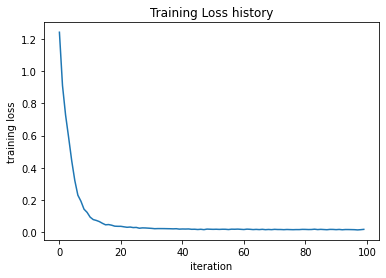

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


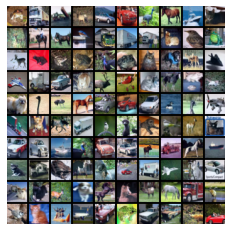

iteration 0 / 1000: loss 2.302954
iteration 100 / 1000: loss 2.302550
iteration 200 / 1000: loss 2.297648
iteration 300 / 1000: loss 2.259602
iteration 400 / 1000: loss 2.204170
iteration 500 / 1000: loss 2.118565
iteration 600 / 1000: loss 2.051535
iteration 700 / 1000: loss 1.988466
iteration 800 / 1000: loss 2.006591
iteration 900 / 1000: loss 1.951473
Validation accuracy:  0.287


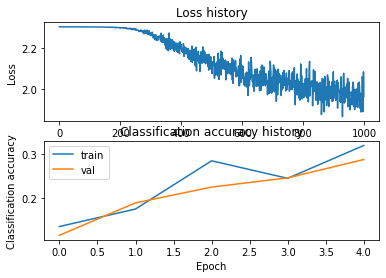

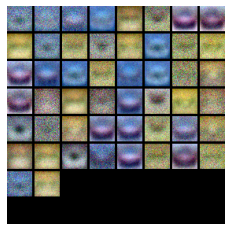

iteration 0 / 20000: loss 2.303238
iteration 100 / 20000: loss 2.071827
iteration 200 / 20000: loss 1.787759
iteration 300 / 20000: loss 1.744972
iteration 400 / 20000: loss 1.652672
iteration 500 / 20000: loss 1.746828
iteration 600 / 20000: loss 1.551190
iteration 700 / 20000: loss 1.471604
iteration 800 / 20000: loss 1.544839
iteration 900 / 20000: loss 1.587784
iteration 1000 / 20000: loss 1.494105
iteration 1100 / 20000: loss 1.525811
iteration 1200 / 20000: loss 1.650700
iteration 1300 / 20000: loss 1.479212
iteration 1400 / 20000: loss 1.392982
iteration 1500 / 20000: loss 1.402051
iteration 1600 / 20000: loss 1.506125
iteration 1700 / 20000: loss 1.480347
iteration 1800 / 20000: loss 1.485251
iteration 1900 / 20000: loss 1.507305
iteration 2000 / 20000: loss 1.347892
iteration 2100 / 20000: loss 1.491202
iteration 2200 / 20000: loss 1.519702
iteration 2300 / 20000: loss 1.370786
iteration 2400 / 20000: loss 1.359644
iteration 2500 / 20000: loss 1.381014
iteration 2600 / 20000: 

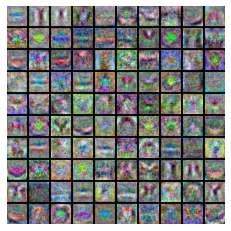

Test accuracy:  0.529


In [ ]:
#-----------------------------------------------------------------------------------
# Implementing a Neural Network In this exercise we will develop a neural
# network with fully-connected layers to perform classification, and test it
# out on the CIFAR-10 dataset.  A bit of setup

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()


#======================================================================================
# Implementing forward pass and the loss functions


input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
    np.random.seed(0)
    return TwoLayerNet(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, input_size)
    y = np.array([0, 1, 2, 2, 1])
    return X, y

net = init_toy_model()
X, y = init_toy_data()


# # Forward pass: compute scores Open the file `two_layernet.py` and look at the
# method `TwoLayerNet.loss`. This function is very similar to the loss
# functions you have written for the SVM and Softmax exercises: It takes the
# data and weights and computes the class scores, the loss, and the gradients
# on the parameters.
#
# Implement the first part of the forward pass which uses the weights and
# biases to compute the scores for all inputs.

scores = net.loss(X)
print('Your scores:')
print(scores)
print()
print('correct scores:')
correct_scores = np.asarray([
 [0.36446210, 0.22911264, 0.40642526],
 [0.47590629, 0.17217039, 0.35192332],
 [0.43035767, 0.26164229, 0.30800004],
 [0.41583127, 0.29832280, 0.28584593],
 [0.36328815, 0.32279939, 0.31391246]])
print(correct_scores)
print()

# The difference should be very small. We get < 1e-7
print('Difference between your scores and correct scores:')
print(np.sum(np.abs(scores - correct_scores)))


# # Forward pass: compute loss In the same function, implement the second part
# that computes the data and regularization loss.
loss, _ = net.loss(X, y, reg=0.05)
correct_loss = 1.30378789133
print("Loss:", loss)

# should be very small, we get < 1e-12
print('Difference between your loss and correct loss:')
print(np.sum(np.abs(loss - correct_loss)))


#======================================================================================
#Computing gradients using back propogation

loss, grads = net.loss(X, y, reg=0.05)

# these should all be less than 1e-8 or so
for param_name in grads:
    f = lambda W: net.loss(X, y, reg=0.05)[0]
    param_grad_num = eval_numerical_gradient(f, net.params[param_name], verbose=False)
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))


#======================================================================================
# Train the network using gradient descent


net = init_toy_model()
stats = net.train(X, y, X, y,
            learning_rate=1e-1, reg=5e-6,
            num_iters=100, verbose=False)

print('Final training loss: ', stats['loss_history'][-1])

# plot the loss history
plt.plot(stats['loss_history'])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()


# # Load the data
# Now that you have implemented a two-layer network that passes
# gradient checks and works on toy data, it's time to load up our favorite
# CIFAR-10 data so we can use it to train a classifier on a real dataset.
# Invoke the get_CIFAR10_data function to get our data.

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

# Visualize some images to get a feel for the data
plt.imshow(visualize_grid(X_train[:100, :].reshape(100, 32,32, 3), padding=3).astype('uint8'))
plt.gca().axis('off')
plt.show()


# # Train a network
# To train our network we will use SGD. In addition, we will
# adjust the learning rate with an exponential learning rate schedule as
# optimization proceeds; after each epoch, we will reduce the learning rate by
# multiplying it by a decay rate.


input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)
# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=1000, batch_size=200,
            learning_rate=1e-4, learning_rate_decay=0.95,
            reg=0.25, verbose=True)



# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)


# # Debug the training
# With the default parameters we provided above, you should get a validation
# accuracy of about 0.29 on the validation set. This isn't very good.
#
# One strategy for getting insight into what's wrong is to plot the loss
# function and the accuracies on the training and validation sets during
# optimization.
#
# Another strategy is to visualize the weights that were learned in the first
# layer of the network. In most neural networks trained on visual data, the
# first layer weights typically show some visible structure when visualized.

# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend()
plt.show()


# Visualize the weights of the network

show_net_weights(net)

best_net = None # store the best model into this

#################################################################################
# TODO: Tune hyperparameters using the validation set. Store your best trained  #
# model in best_net.                                                            #


hidden_size = 100
best_net = TwoLayerNet(input_size, hidden_size, num_classes)

# visualize the weights of the best network
stats = best_net.train(X_train, y_train, X_val, y_val,
            num_iters=20000, batch_size=200,
            learning_rate=0.7 * 1e-3, learning_rate_decay=0.90,
            reg=0.20, verbose=True)

# Predict on the validation set
val_acc = (best_net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)
show_net_weights(best_net)


# # Run on the test set
# When you are done experimenting, you should evaluate your final trained
# network on the test set; you should get above 48%.

test_acc = (best_net.predict(X_test) == y_test).mean()
print('Test accuracy: ', test_acc)


# Implement multi-layer perceptron using PyTorch

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import sys

def weights_init(m):
    if type(m) == nn.Linear:
        m.weight.data.normal_(0.0, 1e-3)
        m.bias.data.fill_(0.)

def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

#--------------------------------
# Device configuration
#--------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: %s'%device)

#--------------------------------
# Hyper-parameters
#--------------------------------
input_size = 32 * 32 * 3
hidden_size = [50]
num_classes = 10
num_epochs = 20
batch_size = 200
learning_rate = 1e-3
learning_rate_decay = 0.95
reg=0.001
num_training= 49000
num_validation =1000
train = True

#-------------------------------------------------
# Load the CIFAR-10 dataset
#-------------------------------------------------
norm_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                     ])
cifar_dataset = torchvision.datasets.CIFAR10(root='datasets/',
                                           train=True,
                                           transform=norm_transform,
                                           download=True)

test_dataset = torchvision.datasets.CIFAR10(root='datasets/',
                                          train=False,
                                          transform=norm_transform,
                                          download= True
                                          )
#-------------------------------------------------
# Prepare the training and validation splits
#-------------------------------------------------
mask = list(range(num_training))
train_dataset = torch.utils.data.Subset(cifar_dataset, mask)
mask = list(range(num_training, num_training + num_validation))
val_dataset = torch.utils.data.Subset(cifar_dataset, mask)

#-------------------------------------------------
# Data loader
#-------------------------------------------------
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)
#======================================================================================
#  Implementing multi-layer perceptron in PyTorch
#======================================================================================
# So far we have implemented a two-layer network using numpy by explicitly
# writing down the forward computation and deriving and implementing the
# equations for backward computation. This process can be tedious to extend to
# large network architectures
#
# Popular deep-learining libraries like PyTorch and Tensorflow allow us to
# quickly implement complicated neural network architectures. They provide
# pre-defined layers which can be used as building blocks to define our
# network. They also enable automatic-differentiation, which allows us to
# define only the forward pass and let the libraries perform back-propagation
# using automatic differentiation.
#
# In this question we will implement a multi-layer perceptron using the PyTorch
# library.  Please complete the code for the MultiLayerPerceptron, training and
# evaluating the model. Once you can train the two layer model, experiment with
# adding more layers and
#--------------------------------------------------------------------------------------

#-------------------------------------------------
# Fully connected neural network with one hidden layer
#-------------------------------------------------
class MultiLayerPerceptron(nn.Module):
    def __init__(self, input_size, hidden_layers, num_classes):
        super(MultiLayerPerceptron, self).__init__()

        layers = []
       
        # layers.append(nn.Flatten())
        layers.append(nn.Linear(input_size,hidden_size[0]))
        layers.append(nn.ReLU())
        # layers.append(nn.Linear(hidden_size[0],hidden_size[0]))
        # layers.append(nn.ReLU())
        # layers.append(nn.Linear(hidden_size[0],hidden_size[0]))
        # layers.append(nn.ReLU())
        # layers.append(nn.Linear(hidden_size[0],hidden_size[0]))
        # layers.append(nn.ReLU())
        # layers.append(nn.Linear(hidden_size[0],hidden_size[0]))
        # layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_size[0], 10))
      
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        out = self.layers(x)
        return out
      


model = MultiLayerPerceptron(input_size, hidden_size, num_classes).to(device)
if train:
    model.apply(weights_init)
    # print(model.layers[0].weight.data)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=reg)

    # Train the model
    lr = learning_rate
    total_step = len(train_loader)
    for epoch in range(num_epochs):
        correct = 0
        total = 0 
        for i, (images, labels) in enumerate(train_loader):
            # if(i>2):
            #     break
            # Move tensors to the configured device
            images = images.to(device)
            labels = labels.to(device)
            #################################################################################
            # TODO: Implement the training code                                             #
          
            images = images.view(200, input_size)
            out = model(images)
            predicted = torch.argmax(out, dim = -1)
            # print(i, images.shape, labels.shape, out.shape)
            # print(i)
            optimizer.zero_grad()
            loss = criterion(out , labels)
            loss.backward()
            optimizer.step()
           

            if (i+1) % 10 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                       .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print('Train accuracy is: {} %'.format(100 * correct / total))
        # Code to update the lr
        lr *= learning_rate_decay
        update_lr(optimizer, lr)
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                ####################################################
                # TODO: Implement the evaluation code              #
                # print(labels.shape)
                images = images.view(200, input_size)
                predicted = model.forward(images)
                # print(predicted.shape)
                predicted = torch.argmax(predicted, dim = -1)
                # print(predicted.shape)

               
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            print('Validataion accuracy is: {} %'.format(100 * correct / total))

    ##################################################################################
    # TODO: Now that you can train a simple two-layer MLP using above code, you can  #
    # easily experiment with adding more layers and different layer configurations   #
    # and let the pytorch library handle computing the gradients                     #
    #                                                                                #
    # Experiment with different number of layers (atleast from 2 to 5 layers) and    #
    # record the final validation accuracies Report your observations on how adding  #
    # more layers to the MLP affects its behavior. Try to improve the model          #
    # configuration using the validation performance as the guidance. You can        #
    # experiment with different activation layers available in torch.nn, adding      #
    # dropout layers, if you are interested. Use the best model on the validation    #
    # set, to evaluate the performance on the test set once and report it            #
    ##################################################################################

    # Save the model checkpoint
    torch.save(model.state_dict(), 'model.ckpt')

else:
    # Run the test code once you have your by setting train flag to false
    # and loading the best model

    best_model = None # torch.load()
    best_model = torch.load('model.ckpt')
    model.load_state_dict(best_model)
    # Test the model
    # In test phase, we don't need to compute gradients (for memory efficiency)
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            ####################################################
            # TODO: Implement the evaluation code              #
           
            images = images.view(200, input_size)
            predicted = model.forward(images)
            predicted = torch.argmax(predicted, dim = -1)          

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            if total == 1000:
                break

        print('Accuracy of the network on the {} test images: {} %'.format(total, 100 * correct / total))

Using device: cpu


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting datasets/cifar-10-python.tar.gz to datasets/
Files already downloaded and verified
Epoch [1/20], Step [10/245], Loss: 2.2042
Epoch [1/20], Step [20/245], Loss: 2.0277
Epoch [1/20], Step [30/245], Loss: 2.0106
Epoch [1/20], Step [40/245], Loss: 1.9456
Epoch [1/20], Step [50/245], Loss: 1.8117
Epoch [1/20], Step [60/245], Loss: 1.8064
Epoch [1/20], Step [70/245], Loss: 1.7573
Epoch [1/20], Step [80/245], Loss: 1.7446
Epoch [1/20], Step [90/245], Loss: 1.8141
Epoch [1/20], Step [100/245], Loss: 1.7643
Epoch [1/20], Step [110/245], Loss: 1.6488
Epoch [1/20], Step [120/245], Loss: 1.6545
Epoch [1/20], Step [130/245], Loss: 1.7760
Epoch [1/20], Step [140/245], Loss: 1.6646
Epoch [1/20], Step [150/245], Loss: 1.6811
Epoch [1/20], Step [160/245], Loss: 1.7154
Epoch [1/20], Step [170/245], Loss: 1.6918
Epoch [1/20], Step [180/245], Loss: 1.6231
Epoch [1/20], Step [190/245], Loss: 1.5960
Epoch [1/20], Step [200/245], Loss: 1.6219
Epoch [1/20], Step [210/245], Loss: 1.6763
Epoch [1/20]